# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
#import findspark
#findspark.init('spark-2.3.2-bin-hadoop2.7')

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
import datetime
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .config("spark.dynamicAllocation.enabled", "false")\
    .config('spark.driver.memory','16g')\
    .config('spark.executor.memory','16g')\
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()


[('spark.dynamicAllocation.enabled', 'false'),
 ('spark.app.id', 'local-1596245093127'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.memory', '16g'),
 ('spark.driver.host', 'MS-MUGMNWGLTHNR'),
 ('spark.driver.port', '52834'),
 ('spark.executor.memory', '16g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project')]

Load and Clean Dataset
In this workspace, the mini-dataset file is mini_sparkify_event_data.json. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 


In [4]:
path='mini_sparkify_event_data.json'
df=spark.read.json(path)

In [5]:
df.cache()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:

df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [7]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910519|
|    min|                  |
|    max|                99|
+-------+------------------+



In [8]:

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
df.count()

286500

In [10]:
df.select('sessionId').dropDuplicates().sort('sessionId').count()

2354

In [11]:
df.where(df.userId=='').show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [12]:
df.where(df.userId=='').count()

8346

In [13]:
df.where(df.sessionId=='').count()

0

In [14]:
df_valid=df.dropna(how='any',subset=['userId','sessionId'])

In [15]:
del df

In [16]:
df_valid=df_valid.filter(df_valid.userId !='')

In [17]:
df_valid.cache()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [18]:
df_valid.count()

278154

In [19]:
df_valid.where(df_valid.userId=='').count()

0

In [20]:
df_valid.where((df_valid.userId=='')&(df_valid.level=='paid')).count()

0

In [21]:

df_valid.where((df_valid.userId=='')&(df_valid.level=='free')).count()

0

In [22]:
df_valid.where(df_valid.sessionId=='').count()

0

In [23]:


df_valid.where(df_valid.level=='paid').count()

222433

In [24]:

df_valid.where(df_valid.level=='free').count()

55721

In [25]:
df_valid.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [26]:
df_valid.select('page').dropDuplicates().sort('page').take(30)

[Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Logout'),
 Row(page='NextSong'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')]

In [27]:
df_valid.filter(df_valid['page']=='Cancellation Confirmation').show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|


In [28]:

df_valid.groupby('page').count().orderBy('page').show(50)

+--------------------+------+
|                page| count|
+--------------------+------+
|               About|   495|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|              Cancel|    52|
|Cancellation Conf...|    52|
|           Downgrade|  2055|
|               Error|   252|
|                Help|  1454|
|                Home| 10082|
|              Logout|  3226|
|            NextSong|228108|
|         Roll Advert|  3933|
|       Save Settings|   310|
|            Settings|  1514|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|         Thumbs Down|  2546|
|           Thumbs Up| 12551|
|             Upgrade|   499|
+--------------------+------+



In [29]:
df_valid.filter(df_valid['page']=='Cancellation Confirmation').count()

52

In [30]:

df_valid.select('page').count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [31]:
churn_user=df_valid.filter(df_valid.page=='Cancellation Confirmation').select('userId')
churn_user_list=list(churn_user.toPandas()['userId'])
df_valid=df_valid.withColumn('churn',df_valid.userId.isin(churn_user_list))

In [32]:
df_valid.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|false|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada| 

In [33]:
churn_user.collect()

[Row(userId='18'),
 Row(userId='32'),
 Row(userId='125'),
 Row(userId='105'),
 Row(userId='17'),
 Row(userId='143'),
 Row(userId='101'),
 Row(userId='129'),
 Row(userId='121'),
 Row(userId='51'),
 Row(userId='87'),
 Row(userId='122'),
 Row(userId='12'),
 Row(userId='58'),
 Row(userId='73'),
 Row(userId='3'),
 Row(userId='106'),
 Row(userId='103'),
 Row(userId='28'),
 Row(userId='54'),
 Row(userId='29'),
 Row(userId='70'),
 Row(userId='53'),
 Row(userId='100011'),
 Row(userId='100001'),
 Row(userId='100024'),
 Row(userId='100006'),
 Row(userId='100019'),
 Row(userId='100003'),
 Row(userId='100023'),
 Row(userId='100005'),
 Row(userId='100017'),
 Row(userId='100025'),
 Row(userId='100009'),
 Row(userId='100012'),
 Row(userId='100013'),
 Row(userId='100022'),
 Row(userId='100014'),
 Row(userId='100015'),
 Row(userId='100021'),
 Row(userId='100007'),
 Row(userId='200001'),
 Row(userId='200024'),
 Row(userId='200011'),
 Row(userId='200021'),
 Row(userId='200018'),
 Row(userId='200015'),
 Ro

In [34]:
churn_user_list

['18',
 '32',
 '125',
 '105',
 '17',
 '143',
 '101',
 '129',
 '121',
 '51',
 '87',
 '122',
 '12',
 '58',
 '73',
 '3',
 '106',
 '103',
 '28',
 '54',
 '29',
 '70',
 '53',
 '100011',
 '100001',
 '100024',
 '100006',
 '100019',
 '100003',
 '100023',
 '100005',
 '100017',
 '100025',
 '100009',
 '100012',
 '100013',
 '100022',
 '100014',
 '100015',
 '100021',
 '100007',
 '200001',
 '200024',
 '200011',
 '200021',
 '200018',
 '200015',
 '200017',
 '200016',
 '200020',
 '300007',
 '300001']

In [35]:
churn_user.toPandas()

,userId
0,18
1,32
2,125
3,105
4,17
5,143
6,101
7,129
8,121
9,51


In [36]:

user_count=df_valid.dropDuplicates(['userId']).count()

In [37]:
user_count

225

In [38]:
df_gender=df_valid.dropDuplicates(['userId']).groupby('gender').count().toPandas()

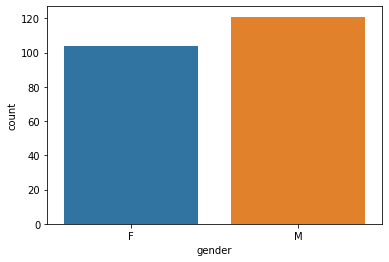

In [39]:
sns.barplot(x='gender',y='count',data=df_gender)

In [40]:
churn_count=df_valid.filter(df_valid.churn==True).dropDuplicates(['userId']).select('userId','churn').count()

In [41]:
churn_false_count=df_valid.filter(df_valid.churn==False).dropDuplicates(['userId']).select('userId','churn').count()

In [42]:
churn_count

52

In [43]:
churn_false_count

173

In [44]:
churn_rate=churn_count/user_count

In [45]:
churn_rate

0.2311111111111111

In [46]:
df_valid.dropDuplicates(['sessionId']).count()

2312

In [47]:
df_valid.dropDuplicates(['artist']).count()

17656

In [48]:

df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: boolean (nullable = true)



In [49]:
df_valid.filter(df_valid.churn==True).head(5)

[Row(artist='Modjo', auth='Logged In', firstName='Alexi', gender='F', itemInSession=0, lastName='Warren', length=250.93179, level='paid', location='Spokane-Spokane Valley, WA', method='PUT', page='NextSong', registration=1532482662000, sessionId=53, song='What I Mean', status=200, ts=1538353930000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0', userId='54', churn=True),
 Row(artist='Edwyn Collins', auth='Logged In', firstName='Alexi', gender='F', itemInSession=1, lastName='Warren', length=216.842, level='paid', location='Spokane-Spokane Valley, WA', method='PUT', page='NextSong', registration=1532482662000, sessionId=53, song="You'll Never Know (My Love) (Bovellian 07 Mix)", status=200, ts=1538354180000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0', userId='54', churn=True),
 Row(artist='Coldplay', auth='Logged In', firstName='Alexi', gender='F', itemInSession=2, lastName='Warren', length=343.32689, level='p

In [50]:
df_valid.filter(df_valid.churn==True).groupby('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|19168|
|     M|25696|
+------+-----+



In [51]:
df_valid.filter(df_valid.churn==True).groupby('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|12388|
| paid|32476|
+-----+-----+



In [52]:
df_valid.groupby('churn').count()

DataFrame[churn: boolean, count: bigint]

In [53]:
df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: boolean (nullable = true)



In [54]:
df_valid.dropDuplicates(["userId"]).groupby(["churn"]).count().sort("churn").show()

+-----+-----+
|churn|count|
+-----+-----+
|false|  173|
| true|   52|
+-----+-----+



In [55]:


withchurn = df_valid.filter(df_valid.churn==True).groupby(["page"]).count()
withchurn_freq = withchurn.withColumn("churnfreq", withchurn["count"]/(churn_count/100)).sort("page")
withchurn_freq=withchurn_freq.withColumnRenamed('count','churncount')
withoutchurn = df_valid.filter(df_valid.churn==False).groupby(["page"]).count()
withoutchurn_freq = withoutchurn.withColumn("nochurnfreq", withoutchurn["count"]/(churn_false_count/100)).sort("page")
withoutchurn_freq=withoutchurn_freq.withColumnRenamed('count','nochurncount')

In [56]:
rate=withchurn_freq.join(withoutchurn_freq,'page','outer')

In [57]:
rate=rate.withColumn('rate',(rate.nochurnfreq)/(rate.churnfreq)).sort('rate')

In [58]:
rate=rate.select('page','rate')

In [59]:
df_rate=rate.fillna(0).toPandas()

In [60]:
df_rate.head(20)

,page,rate
0,Cancel,0.000000
1,Cancellation Confirmation,0.000000
2,Roll Advert,0.921938
3,Upgrade,1.038604
4,Submit Upgrade,1.192919
5,Thumbs Down,1.242308
6,Save Settings,1.305960
7,Settings,1.384885
8,Logout,1.452884
9,Home,1.511879


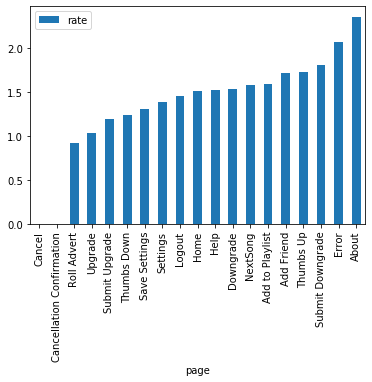

In [61]:
df_rate.plot.bar('page')

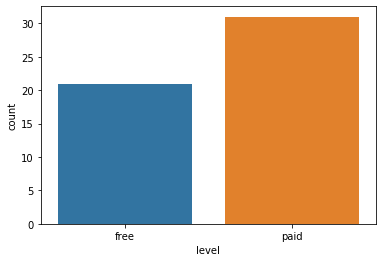

In [62]:
df_pd = df_valid.filter(df_valid.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [63]:
songs_quantity=df_valid.filter(df_valid.page=='NextSong').groupBy('userId').count().withColumnRenamed('count','songs_quantity').sort('userId')

In [65]:
df_valid.select('userId','gender').dropDuplicates().count()

225

In [66]:
df_maxts=df_valid.groupBy('userId').agg({'ts':'max'}).withColumnRenamed('max(ts)','maxts').sort('userId')

In [67]:
df_regist=df_valid.select('userId','registration').dropDuplicates().sort('userId')

In [68]:
df_reg=df_regist.join(df_maxts,df_regist.userId==df_maxts.userId).select(df_regist['userId'],((df_maxts['maxts']-df_regist['registration'])/(1000*60*60*24)).alias('reg1day')).sort('userId')

In [69]:
df_reg.printSchema()

root
 |-- userId: string (nullable = true)
 |-- reg1day: double (nullable = true)



In [70]:
usergender=df_valid.select("userId", "gender").dropDuplicates().replace(['M','F'],['1','0'],'gender').sort('userId')

In [71]:
usergender=usergender.select('userId',usergender.gender.cast('int'))

In [72]:
thumbs_up=df_valid.filter(df_valid.page=='Thumbs Up').groupBy('userId').count().withColumnRenamed('count','thumbup').sort('userId')

In [73]:
Addfriend=df_valid.filter(df_valid.page=='Add Friend').groupBy('userId').count().withColumnRenamed('count','addfriend').sort('userId')

In [74]:
addtoplaylist=df_valid.filter(df_valid.page=='Add to Playlist').groupBy('userId').count().withColumnRenamed('count','addtoplaylist').sort('userId')

In [75]:
user_session_time = df_valid.groupby("userId", "sessionId").agg(((max(df_valid.ts)-min(df_valid.ts))/(1000*60)).alias("sessionTime"))


In [76]:
total_listen_time=user_session_time.groupby("userId").agg({'sessionTime':'sum'}).withColumnRenamed('sum(sessionTime)','totallistentime').sort('userId')

In [77]:
user_churn = df_valid.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))

In [78]:
user_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
+------+-----+
only showing top 5 rows



In [79]:
# put all the features dataframe into a list
features_list = []
features_list.append(songs_quantity)
features_list.append(df_reg)
features_list.append(usergender)
features_list.append(thumbs_up)
features_list.append(Addfriend)
features_list.append(addtoplaylist)
features_list.append(total_listen_time)
features_list.append(user_churn)

In [80]:
dataset = df_valid.select("userId").dropDuplicates().sort('userId')

In [83]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "Temp")
    df = df1.join(df2, df1.userId == df2.Temp, "left").drop("Temp")
    return df

In [84]:
# use function to merge the features in the list
for feature in features_list:
    dataset = features_merge(dataset, feature)

In [85]:
dataset.cache()
dataset.show(5)

+------+--------------+------------------+------+-------+---------+-------------+------------------+-----+
|userId|songs_quantity|           reg1day|gender|thumbup|addfriend|addtoplaylist|   totallistentime|churn|
+------+--------------+------------------+------+-------+---------+-------------+------------------+-----+
|100010|           275| 55.64365740740741|     0|     17|        4|            7|1081.3833333333332|    0|
|200002|           387| 70.07462962962963|     1|     21|        4|            8|            1598.4|    0|
|   125|             8| 71.31688657407408|     1|   null|     null|         null|29.566666666666666|    1|
|   124|          4079|131.55591435185184|     0|    171|       74|          118|16790.833333333336|    0|
|    51|          2111|19.455844907407407|     1|    100|       28|           52| 8723.566666666666|    1|
+------+--------------+------------------+------+-------+---------+-------------+------------------+-----+
only showing top 5 rows



In [86]:
dataset.printSchema()

root
 |-- userId: string (nullable = true)
 |-- songs_quantity: long (nullable = true)
 |-- reg1day: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- thumbup: long (nullable = true)
 |-- addfriend: long (nullable = true)
 |-- addtoplaylist: long (nullable = true)
 |-- totallistentime: double (nullable = true)
 |-- churn: integer (nullable = true)



In [133]:
dataset.columns[1:-1]

['songs_quantity',
 'reg1day',
 'gender',
 'thumbup',
 'addfriend',
 'addtoplaylist',
 'totallistentime']

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [87]:
assembler = VectorAssembler(inputCols=dataset.columns[1:-1], outputCol="NumFeatures")
data = assembler.setHandleInvalid('skip').transform(dataset)

In [88]:
data.show(1)

+------+--------------+-----------------+------+-------+---------+-------------+------------------+-----+--------------------+
|userId|songs_quantity|          reg1day|gender|thumbup|addfriend|addtoplaylist|   totallistentime|churn|         NumFeatures|
+------+--------------+-----------------+------+-------+---------+-------------+------------------+-----+--------------------+
|100010|           275|55.64365740740741|     0|     17|        4|            7|1081.3833333333332|    0|[275.0,55.6436574...|
+------+--------------+-----------------+------+-------+---------+-------------+------------------+-----+--------------------+
only showing top 1 row



In [89]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [90]:
data = data.select(data.churn.alias("label"), data.ScaledNumFeatures.alias("features"))

In [91]:
train, validation = data.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

In [134]:
train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.24639366220597...|
|    0|[0.34674308099531...|
|    0|[0.13439654302144...|
|    0|[3.65468999322970...|
|    1|[1.89140734878840...|
|    0|[1.71489988895358...|
|    1|[2.54547052482608...|
|    0|[0.73470110185054...|
|    0|[0.07526206409200...|
|    0|[1.72744356630224...|
|    1|[0.23026607704340...|
|    1|[1.61007058539685...|
|    1|[0.20607469929954...|
|    1|[2.71301821512614...|
|    0|[0.19263504499739...|
|    0|[3.20132565477071...|
|    1|[0.33778331146055...|
|    0|[0.04121493985990...|
|    0|[0.21234653797387...|
|    0|[1.26959934307587...|
+-----+--------------------+
only showing top 20 rows



In [93]:

linereg =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(linereg.elasticNetParam,[0.0, 0.1]) \
    .addGrid(linereg.regParam,[0.0, 0.05]) \
    .build()

crossval = CrossValidator(estimator=linereg,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)


In [94]:
model_linereg = crossval.fit(train)

In [95]:
model_linereg.save('model_linereg.model')

In [96]:
model_linereg.avgMetrics

[0.7495111440611484, 0.729897030965296, 0.7495111440611484, 0.729897030965296]

In [97]:
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 4]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)



In [98]:
model_dt = crossval_dt.fit(train)

In [99]:
model_dt.save('model_dt.model')

In [100]:
model_dt.avgMetrics

[0.7330243156905613,
 0.7485855538182258,
 0.7873571173917839,
 0.7590869030683711]

In [101]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10]) \
    .addGrid(gbt.maxDepth,[2, 4]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)



In [102]:
model_gbt = crossval_gbt.fit(train)

In [103]:
model_gbt.save('model_gbt.model')

In [104]:
model_gbt.avgMetrics

[0.7873571173917839,
 0.7500494466465001,
 0.7899361610074308,
 0.7441709057635567]

In [143]:
results = model_gbt.transform(validation)

In [144]:
results.show(200)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.57969708889914...|[0.81962865815120...|[0.83743385499040...|       0.0|
|    0|[1.85467229369588...|[1.00299616931904...|[0.88142480083923...|       0.0|
|    0|[3.25418829502581...|[1.00299616931904...|[0.88142480083923...|       0.0|
|    0|[1.00797407266080...|[0.84075544840811...|[0.84310449511837...|       0.0|
|    1|[0.68721432331629...|[0.79811488906343...|[0.83149078481237...|       0.0|
|    1|[0.19173906804392...|[0.81962865815120...|[0.83743385499040...|       0.0|
|    0|[0.33778331146055...|[0.81962865815120...|[0.83743385499040...|       0.0|
|    0|[0.57521720413176...|[0.84351286219756...|[0.84383261311739...|       0.0|
|    0|[0.60478444359648...|[0.81962865815120...|[0.83743385499040...|       0.0|
|    0|[1.614550

In [145]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)
print(tp)
print(fp)
print(fn)

1.0
0.42857142857142855
0.6
3
0
4


In [146]:
results2 = model_linereg.transform(validation)

In [147]:
tp = results2.filter("label = 1 and prediction = 1").count()
fp = results2.filter("label = 0 and prediction = 1").count()
fn = results2.filter("label = 1 and prediction = 0").count()
#precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)
print(tp)
print(fp)
print(fn)

1.0
0.0
0.0
0
0
7


In [150]:
results3 = model_dt.transform(validation)

In [151]:
tp = results3.filter("label = 1 and prediction = 1").count()
fp = results3.filter("label = 0 and prediction = 1").count()
fn = results3.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)
print(tp)
print(fp)
print(fn)

1.0
0.42857142857142855
0.6
3
0
4


In [ ]:
dataset.columns

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.